## Group Project "Boolean Pandemic"

### Predict who is more likely to survive to the pandemic

**Group:**
- Pedro Santos
- Lennart Dangers
- Federica Murillo
- Ana Claudia Alferes
- Alexandra Ordina

Link to Kaggle:


### Code structure:

* [1. Libraries](#lib)
* [2. Functions](#functions)
* [3. Data exploration](#explore)
* [4. Data pre-processing](#preprocess)
* [5. Feature engineering](#engineer)
* [6. Features selection](#features)
* [7. Modelling](#model)
* [8. Finetuning](#finetune)
* [9. Test submission](#test)
* [10. Conclusion](#conclusion)


## Dataset

**Data fields:**
    
- **Patient_ID** - The unique identifier of the patient
- **Family_Case_ID** - The family identification
- **Severity** - The severity of the disease, where 1 is the lowest and 3 the highest severity
- **Name** - The name of the patient
- **Birthday_year** - The year of birthday of the patient
- **Parents_Siblings_Infected** - The number of parents and/or siblings infected
- **Partner_Children_Infected** - The number of partner and/or children infected
- **Medical_Expenses_Family** - The medical expenses associated to try to contain the epidemy on the family
- **Medical_Tent** - The medical tent where the patient is / was lodged
- **City** - The original city of the patient
- **Deceased** - Flag if the patient deceased or not with the virus (0 = No, 1 = Yes)

<hr>
<a class="anchor" id="lib">

### 1. Libraries
    
</a>

In [42]:
#pip install xgboost
import warnings
warnings.filterwarnings('ignore')
import time
from sklearn.neural_network import MLPClassifier
import pandas as pd
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFE, RFECV
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV,LassoCV,RidgeCV, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.impute import KNNImputer
from sklearn.svm import SVC, LinearSVC
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sb
import math
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from xgboost import XGBClassifier
from sklearn.preprocessing import RobustScaler, StandardScaler, LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn import metrics
import optuna
import functools

<hr>
<a class="anchor" id="functions">

### 2. Functions
    
</a>

In [43]:
def avg_score(model):
    """
    Splits the model in with cross fold validation and returns the avg training and testing score.
    """
    # apply kfold
    kf = KFold(n_splits=5)
    # create lists to store the results from the different models 
    score_train = []
    score_test = []
    for train_index, val_index in kf.split(X):
        # get the indexes of the observations assigned for each partition
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        #standardize the model
        scaler = StandardScaler()
        X_train=scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)
        # fit the model to the data
        model.fit(X_train, y_train)
        # check the mean accuracy for the train
        value_train = model.score(X_train, y_train)
        # check the mean accuracy for the test
        value_test = model.score(X_val,y_val)
        # append the accuracies, the time and the number of iterations in the corresponding list
        score_train.append(value_train)
        score_test.append(value_test)
    # calculate the average and the std for each measure (accuracy, time and number of iterations)
    avg_train = round(np.mean(score_train),3)
    avg_test = round(np.mean(score_test),3)
    std_train = round(np.std(score_train),2)
    std_test = round(np.std(score_test),2)

    return avg_train,std_train, avg_test, std_test

In [44]:
def cor_heatmap(cor):
    """Plots a heatmap plot"""
    plt.figure(figsize=(20,20))
    sb.heatmap(data = cor, annot = True, cmap = plt.cm.Reds, fmt='.1')
    plt.show()

In [45]:
def plt_box(data):
    """Plots a boxplot"""
    n_col = 2
    n_row = 2
    fig, ax = plt.subplots(n_row, n_col, figsize=(15, 10))
    for var, subplot in zip(data[numerical], ax.flatten()):
        sb.boxplot(data[var], ax=subplot)

In [46]:
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

In [47]:
def split_scale(X,y,scale,size_test):
    """ This function scales the input dataset (X and y) and split both into train- and test sets
    Input: 
    X: Unscaled and unlabeled data
    y: The labels for X
    scale: choose between "StandardScaler", "MinMaxScaler" or "RobustScaler"
    size_test: size in percent of the test set 
    Output: X_train, X_test, y_train, y_test
    """
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=size_test,random_state=0,stratify =y)
    if scale == "RobustScaler":
        robust = RobustScaler().fit(X_train)
        X_train = robust.transform(X_train)
        X_test = robust.transform(X_test)
        return X_train, X_test,y_train,y_test
    elif scale == "MinMaxScaler":
        minmax = MinMaxScaler().fit(X_train)
        X_train = minmax.transform(X_train)
        X_test = minmax.transform(X_test)
        return X_train, X_test,y_train,y_test
    elif scale == "StandardScaler":
        scaler = StandardScaler().fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
        return X_train, X_test,y_train,y_test

In [48]:
def model_compare_kf(list_of_models):
    """
    Receives a list of models, trains them and tests against each other, using KF technique with avg_score function.
    """
    train_score=[]
    train_std = []
    val_std = []
    val_score=[]
    model_used=[]
    for i in list_of_models:
        avg_train,std_train, avg_test, std_test = avg_score(i)
        model_used.append(str(i))
        train_score.append(avg_train)
        train_std.append(std_train)
        val_std.append(std_test)
        val_score.append(avg_test)

    df = pd.DataFrame([model_used, train_score, train_std, val_score, val_std], index=["model","train_score","train_std","val_score","val_std"]).T.sort_values(by="val_score", ascending=False)
    return df

In [49]:
def model_compare(list_of_models):
    """Receives a list of models, trains them and tests against each other"""
    train_score=[]
    val_score=[]
    model_used=[]
    for i in list_of_models:
        model = i
        model.fit(X_train, y_train)
        train_score.append(model.score(X_train, y_train))
        val_score.append(model.score(X_val, y_val))
        model_used.append(str(i))
        y_pred = model.predict(X_val)
    df = pd.DataFrame([model_used, train_score, val_score], index=["model","train_score","val_score"]).T.sort_values(by="val_score", ascending=False)
    return df

In [50]:
def opt_gdb(X_train, y_train, X_test, y_test, trial):
    """Uses Optuna to finetune the Gradient Boosting Classifier"""
    #param_list
    n_estimators = trial.suggest_int('n_estimators', 1, 1000)
    max_depth = trial.suggest_int('max_depth', 1, 40)
    criterion = trial.suggest_categorical('criterion', ['friedman_mse', 'mse', 'mae'])
    learning_rate = trial.suggest_discrete_uniform('learning_rate', 0.001, 0.2, 0.001)
    subsample = trial.suggest_discrete_uniform('subsample', 0.5, 0.9, 0.1)
    loss=trial.suggest_categorical('loss', ['deviance', 'exponential'])
    min_samples_split=trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf=trial.suggest_int('min_samples_leaf', 1, 20)
    min_weight_fraction_leaf=trial.suggest_discrete_uniform('min_weight_fraction_leaf', 0, 0.5, 0.001)
    max_features=trial.suggest_int('max_features', 1, len(X_train.columns))
    
    gb_tuna = GradientBoostingClassifier(
        criterion = criterion,
        random_state=150, 
        n_estimators = n_estimators,
        max_depth = max_depth,
        learning_rate = learning_rate,
        subsample = subsample,
        loss=loss,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        min_weight_fraction_leaf=min_weight_fraction_leaf,
        max_features=max_features
 
    )
    gb_tuna.fit(X_train, y_train)
    tuna_pred_test = gb_tuna.predict(X_val)
    
    return (metrics.accuracy_score(y_test, tuna_pred_test))

<hr>
<a class="anchor" id="explore">

### 3. Data exploration
    
</a>

### Full dataset exploration

In [51]:
Pandemic = pd.read_csv("train.csv")
Pandemic.describe(include='all')

,Patient_ID,Family_Case_ID,Severity,Name,Birthday_year,Parents or siblings infected,Wife/Husband or children infected,Medical_Expenses_Family,Medical_Tent,City,Deceased
count,900.000000,900.000000,900.000000,900,723.000000,900.000000,900.000000,900.000000,198,898,900.000000
unique,NaN,NaN,NaN,899,NaN,NaN,NaN,NaN,8,3,NaN
top,NaN,NaN,NaN,Mr. Samuel Darnell,NaN,NaN,NaN,NaN,C,Santa Fe,NaN
freq,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,57,649,NaN
mean,450.500000,14305.827778,2.313333,NaN,1990.266943,0.380000,0.521111,895.743333,NaN,NaN,0.614444
std,259.951919,25418.153900,0.834223,NaN,14.523335,0.803247,1.098385,1385.829926,NaN,NaN,0.486997
min,1.000000,345.000000,1.000000,NaN,1940.000000,0.000000,0.000000,0.000000,NaN,NaN,0.000000
25%,225.750000,8203.000000,2.000000,NaN,1982.000000,0.000000,0.000000,221.000000,NaN,NaN,0.000000
50%,450.500000,13593.500000,3.000000,NaN,1992.000000,0.000000,0.000000,405.000000,NaN,NaN,1.000000
75%,675.250000,18906.500000,3.000000,NaN,1999.500000,0.000000,1.000000,861.250000,NaN,NaN,1.000000


In [52]:
# Check missing values
print(Pandemic.isnull().sum())

Patient_ID                             0
Family_Case_ID                         0
Severity                               0
Name                                   0
Birthday_year                        177
Parents or siblings infected           0
Wife/Husband or children infected      0
Medical_Expenses_Family                0
Medical_Tent                         702
City                                   2
Deceased                               0
dtype: int64


In [53]:
Pandemic[Pandemic.Birthday_year != Pandemic.Birthday_year]

,Patient_ID,Family_Case_ID,Severity,Name,Birthday_year,Parents or siblings infected,Wife/Husband or children infected,Medical_Expenses_Family,Medical_Tent,City,Deceased
0,1,4696,3,Miss Linda Betty,NaN,0,0,225,NaN,Santa Fe,1
5,6,17598,2,Master Terrell Bob,NaN,0,0,0,NaN,Santa Fe,1
9,10,14392,3,Miss Elena Cathy,NaN,1,1,626,F,Albuquerque,0
14,15,6507,3,Miss Pearl Elsie,NaN,0,0,217,NaN,Taos,0
15,16,19174,3,Master Alfredo Marty,NaN,0,0,211,NaN,Santa Fe,1
...,...,...,...,...,...,...,...,...,...,...,...
869,870,3539,3,Master Duane Dallas,NaN,0,0,423,NaN,Santa Fe,1
870,871,4275,3,Master Louis Elias,NaN,0,0,202,NaN,Albuquerque,1
871,872,11524,1,Master Bryan Vincent,NaN,0,0,0,NaN,Santa Fe,1
876,877,4392,3,Master Warren Ivan,NaN,0,0,216,NaN,Taos,1


**Initial considerations:**

We have 900 patients records
* one patient name repeats once but looking at the patients info we conclude these are two different people with same names
* Families can be tracked by Family_case_ID
* Birthday Year not available for everyone - fill in with KNNFiller? Also easier to work with age so will create a column "Age"(as of January 1st, 2020 when epidemic started)
* City has two missing values - fill in with KNNImputer?
* Medical tent can be unknown? (are there patients without tent or its data collection error?) so we cannot realy extrapolate these values and there are too many patients without Tent (almost 80%)
* Medical tent has many categories (8). This can indicate an issue with distribution. Can convert to binary (Tent - Yes-No).
* target value (deceased or not) is evenly distributed



In [54]:
# Exploration of categorical variables: cross table of Tents and city and severity of infection
table1 = pd.crosstab(index=Pandemic['City'], columns=Pandemic['Severity'])
table1

Severity,1,2,3
City,,,
Albuquerque,85,17,67
Santa Fe,127,165,357
Taos,2,4,74


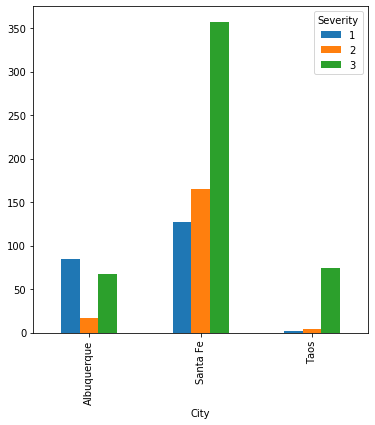

In [55]:
# Visual exploration of the cross table
table1.plot(kind="bar", 
                 figsize=(6,6),
                 stacked=False)

In [56]:
table1 = pd.crosstab(index=Pandemic['Medical_Tent'], columns=Pandemic['Severity'])
table1

Severity,1,2,3
Medical_Tent,,,
A,15,0,0
B,46,0,0
C,56,0,1
D,27,4,0
E,24,4,3
F,0,8,5
G,0,0,4
T,1,0,0


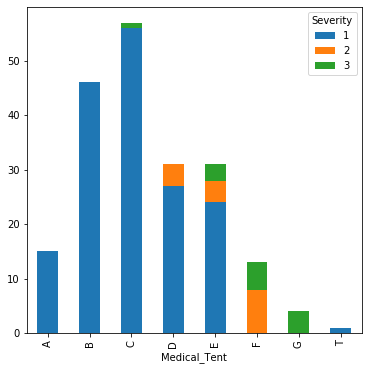

In [57]:
# Visual exploration of the cross table
table1.plot(kind="bar", 
                 figsize=(6,6),
                 stacked=True)

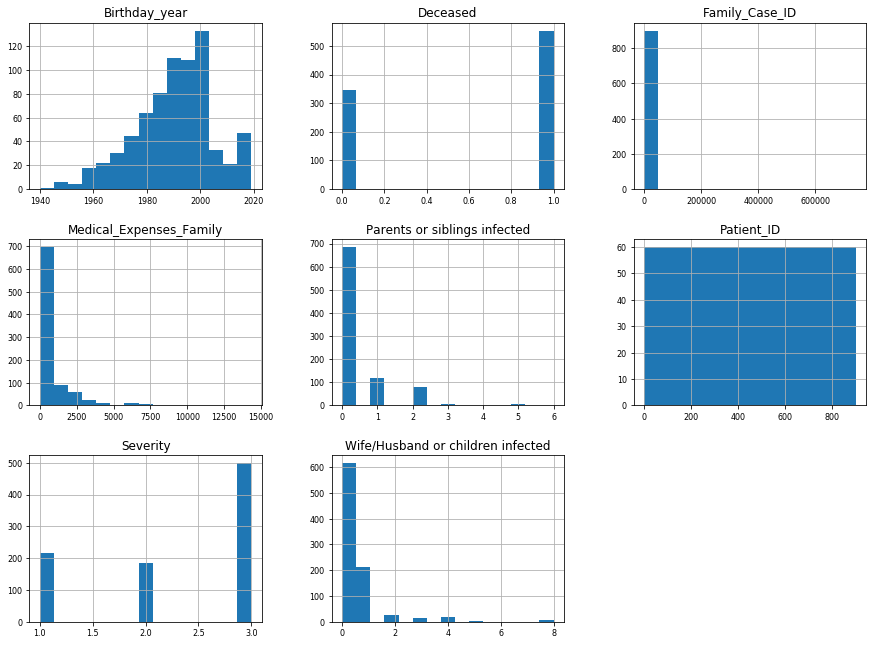

In [58]:
# Do histograms on all numeric variables
numerical=Pandemic.select_dtypes(include=[np.number]).columns.tolist()
Pandemic[numerical].hist(bins=15, figsize=(15, 15), layout=(4, 3), xlabelsize=8, ylabelsize=8);

Age has somewhat normal distribution, but Medical expenses need to be transformed. Also Infected family needs to be looked at.

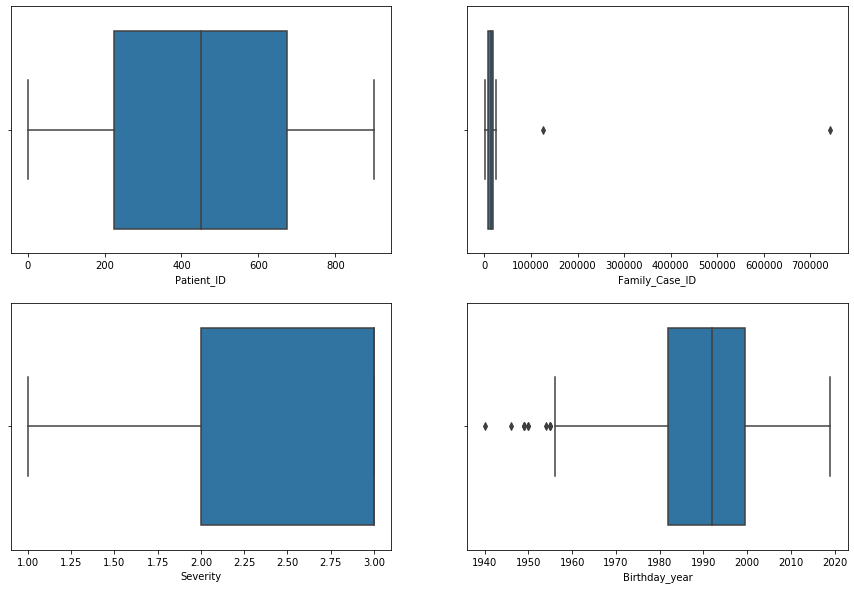

In [59]:
# Boxplots on all numeric variables
plt_box(Pandemic[numerical])

### Exploration of variables in relation to target

In [60]:
#average metrics for Deceased and Survivors to get initial insights
Pandemic.groupby('Deceased').mean()

,Patient_ID,Family_Case_ID,Severity,Birthday_year,Parents or siblings infected,Wife/Husband or children infected,Medical_Expenses_Family
Deceased,,,,,,,
0,449.423631,13619.536023,1.962536,1991.698305,0.463977,0.475504,1340.755043
1,451.175407,14736.466546,2.533454,1989.280374,0.327306,0.549729,616.504521


In [61]:
#Exploring categorical features
piv1=pd.pivot_table(Pandemic, values='Patient_ID', index=['City'], columns=['Deceased'],aggfunc='count')
piv2=pd.pivot_table(Pandemic, values='Patient_ID', index=['Severity'], columns=['Deceased'],aggfunc='count')
piv3=pd.pivot_table(Pandemic, values='Patient_ID', index=['Medical_Tent'], columns=['Deceased'],aggfunc='count')

display_side_by_side(piv1,piv2,piv3)


Deceased,0,1
City,,
Albuquerque,94,75
Santa Fe,221,428
Taos,30,50
Deceased,0,1
Severity,,
1,136,80
2,88,98
3,123,375
Deceased,0,1


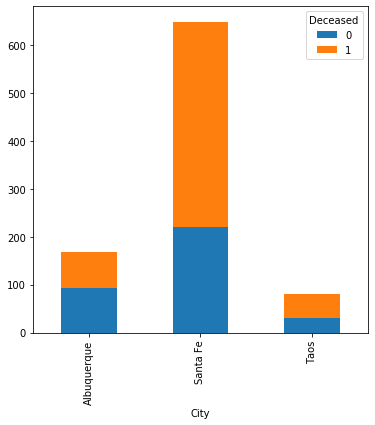

In [62]:
piv1.plot(kind="bar", 
                 figsize=(6,6),
                 stacked=True)

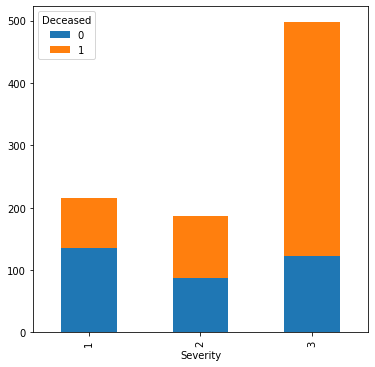

In [63]:
piv2.plot(kind="bar", 
                 figsize=(6,6),
                 stacked=True)

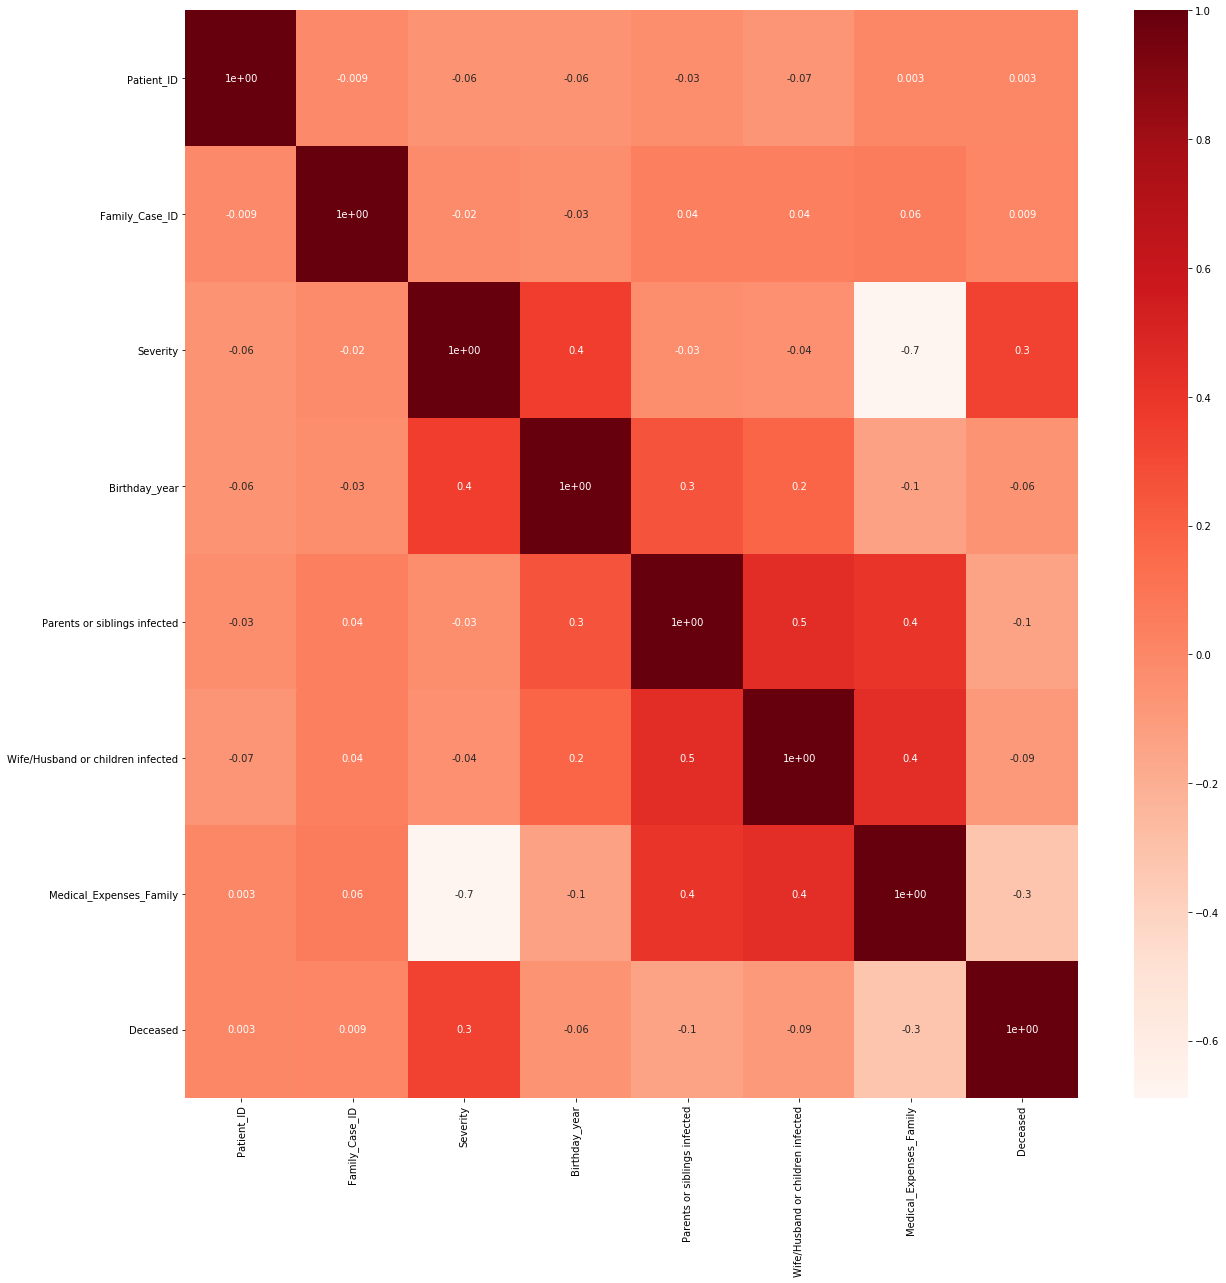

In [64]:
corr_df = Pandemic.corr('spearman')
cor_heatmap(corr_df)

In [65]:
abs(corr_df['Deceased']).sort_values(ascending=False)

Deceased                             1.000000
Severity                             0.334289
Medical_Expenses_Family              0.319579
Parents or siblings infected         0.140860
Wife/Husband or children infected    0.093854
Birthday_year                        0.058452
Family_Case_ID                       0.009041
Patient_ID                           0.003282
Name: Deceased, dtype: float64

**Some conclusions relating to target variable and input features**

* Family infected - younger patients die less, lower average in "Parents or siblings infected" can be explained by this. Also the two variables for infected in family seem to relay similar info so potentially can be merged into one feature "Family members infected" which reflects sum of the two columns
* Discard of "Medical_Tent" as almost 80% records do not have it or replace nulls with 9th category "No Tent"
* Create age variable
* Santa Fe has worst situation for severity of disease and number of infected, Albuquerque is next in number of infected but still has more people with lighter form of illness than the severe
* Survivors have spent more on medical expenses
* Severity, Medical expenses and Birthday Year are highly correlated.
* Partners/kids and parents/siblings are correlated

 **Severity, Medical expenses and infected family are most important features for the outcome of the illness**


<hr>
<a class="anchor" id="preprocess">

### 4. Data pre-processing
    
</a>

In [66]:
#dropping missing city
Pandemic.dropna(subset=['City'],axis=0,inplace=True)

#filling the missing Medical tent with "None"
Pandemic['Medical_Tent'].fillna('None',inplace=True)

#filling the missing Birthday Year with precicted values
imputer = KNNImputer(n_neighbors=3)
imputer.fit(Pandemic[['Birthday_year']])
Birthday_imputed = imputer.transform(Pandemic[['Birthday_year']])
Birthday_imputed = pd.DataFrame(Birthday_imputed, columns = Pandemic[['Birthday_year']].columns, index = Pandemic.index)
Birthday_imputed = Birthday_imputed.astype(int)
Pandemic = Pandemic.assign(Birthday_year=Birthday_imputed['Birthday_year'])

Pandemic.head()

,Patient_ID,Family_Case_ID,Severity,Name,Birthday_year,Parents or siblings infected,Wife/Husband or children infected,Medical_Expenses_Family,Medical_Tent,City,Deceased
0,1,4696,3,Miss Linda Betty,1990,0,0,225,None,Santa Fe,1
1,2,21436,1,Ms. Ramona Elvira,1966,0,1,1663,None,Albuquerque,0
2,3,7273,3,Mr. Mario Vernon,1982,0,0,221,None,Santa Fe,1
3,4,8226,3,Mr. Hector Joe,1997,0,0,220,None,Santa Fe,1
4,5,19689,3,Ms. Jennie Debra,1994,0,0,222,None,Santa Fe,0


In [67]:
#Check missing values in dataset
print(Pandemic.isnull().sum())

Patient_ID                           0
Family_Case_ID                       0
Severity                             0
Name                                 0
Birthday_year                        0
Parents or siblings infected         0
Wife/Husband or children infected    0
Medical_Expenses_Family              0
Medical_Tent                         0
City                                 0
Deceased                             0
dtype: int64


In [68]:
#create new variables age and Family infected 
Pandemic['Age']=2020-Pandemic['Birthday_year']
Pandemic.drop(['Birthday_year'],axis=1,inplace=True)

#create new variable Family_infected
#Pandemic['Family_infected']=Pandemic['Parents or siblings infected']+Pandemic['Wife/Husband or children infected']
#Pandemic.drop(['Parents or siblings infected','Wife/Husband or children infected'],axis=1,inplace=True)

In [69]:
#drop name column
#Pandemic.drop(['Name',"Patient_ID","Family_Case_ID"],axis=1,inplace=True)

#### Encoding categorical

In [70]:
# Encode categorical variables to dummy variables
import category_encoders as ce
encode = ['City', 'Medical_Tent']
ce_one_hot = ce.OneHotEncoder(cols = encode, use_cat_names=True)
encoded = ce_one_hot.fit_transform(Pandemic[encode])

complete = pd.concat([Pandemic, encoded], axis=1)
complete.drop(encode,axis=1,inplace=True)

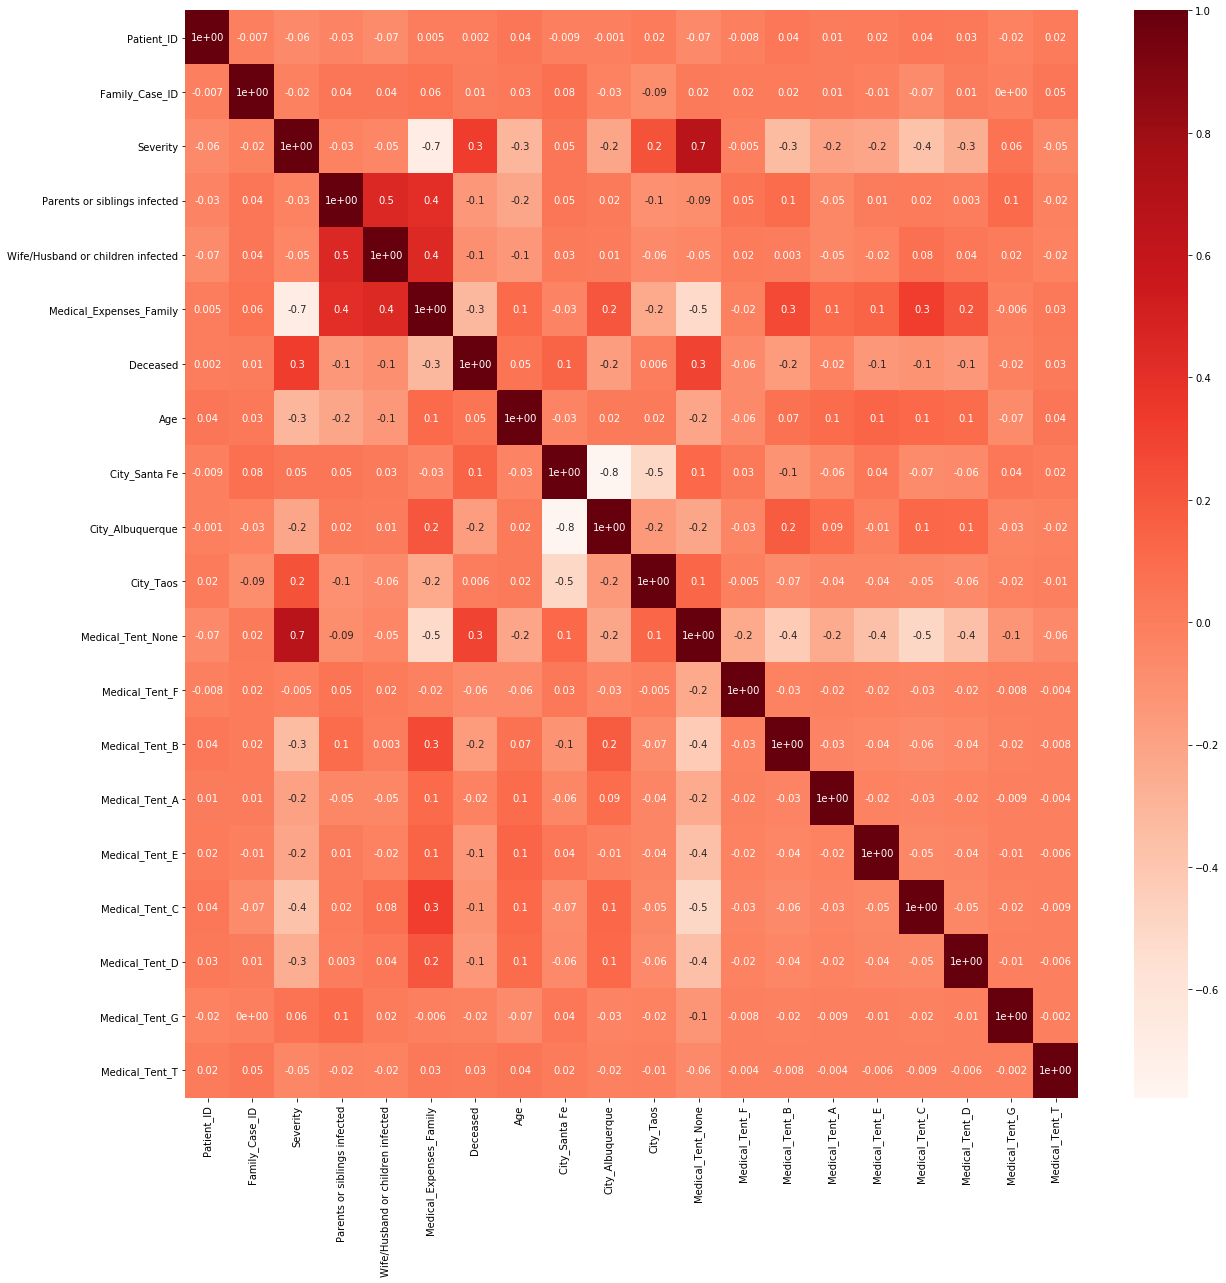

In [71]:
cor_heatmap(complete.corr('spearman'))

In [72]:
#complete.drop('City_Albuquerque', axis=1, inplace=True)

In [73]:
abs(complete.corr()['Deceased']).sort_values(ascending=False)

Deceased                             1.000000
Severity                             0.330357
Medical_Tent_None                    0.297630
Medical_Expenses_Family              0.252494
City_Albuquerque                     0.170286
Medical_Tent_B                       0.160105
City_Santa Fe                        0.144925
Medical_Tent_D                       0.139076
Medical_Tent_E                       0.139076
Medical_Tent_C                       0.113632
Parents or siblings infected         0.084364
Age                                  0.079661
Medical_Tent_F                       0.057609
Wife/Husband or children infected    0.031639
Medical_Tent_T                       0.026372
Family_Case_ID                       0.022422
Medical_Tent_A                       0.022101
Medical_Tent_G                       0.015927
City_Taos                            0.005907
Patient_ID                           0.001555
Name: Deceased, dtype: float64

<hr>
<a class="anchor" id="engineer">

### 5. Feature engineering
    
</a>

In [74]:
fe = complete.copy()

In [75]:
#logging expenses
fe["Medical_Expenses_Family_log"] = fe.Medical_Expenses_Family.apply(lambda x: np.log(x+1))

We decided to make this log transformation in order to handle skewed data, normalize the magnitude differences and decreasing the effect of the outliers with the goal to help the model to learn better.

In [76]:
#new feature based on count of all family members both from test and train sets
Pandemic_test = pd.read_csv("test.csv")
Pandemic_test['Deceased'] = 0
fc_test=Pandemic_test[["Family_Case_ID","Deceased","Severity"]]
fc_train = fe[["Family_Case_ID","Deceased","Severity"]]
fc_all = pd.concat([fc_train,fc_test])
fc_all.head()

,Family_Case_ID,Deceased,Severity
0,4696,1,3
1,21436,0,1
2,7273,1,3
3,8226,1,3
4,19689,0,3


In this cell we combine both the train and test dataset to check the total of members per family that are infected and the corresponding severity since some members were splitted between the train and test dataset.

In [77]:
grouped_severity=fc_all[["Family_Case_ID","Severity"]].groupby(['Family_Case_ID']).mean()
grouped_severity.rename(columns={"Severity":"avgFamSeverity"},inplace=True)
grouped_severity.head()

,avgFamSeverity
Family_Case_ID,
345,2.0
981,3.0
1162,3.0
1681,2.0
1761,3.0


This step tell us the average severity between the different members of the family. 

In [78]:
# Create a feature "Family_infected" to show how many members of family are infected
fcid = fc_all["Family_Case_ID"].value_counts()
fe = fe.merge(fcid, left_on="Family_Case_ID", right_on = fcid.index)
fe["Family_Infected"] = fe.Family_Case_ID_y - 1 #subtract the person
fe = fe.merge(grouped_severity, left_on="Family_Case_ID", right_on = grouped_severity.index)

This new computed feature created above named "Family_Infected" show us the number of members in the family that are infected, not counting the person pacient itself.

In [79]:
# create a feature "Gender": If the name begins with Mr. or Master it is a male (encoded:0), if not, it is a female (encoded:1)
fe["NameSplit"]=fe.Name.str.rsplit()
fe["Gender"] = fe.NameSplit.apply(lambda x: 0 if x[0]=="Mr." or x[0]=="Master" else 
                                      (1))
fe.drop(columns=["NameSplit"],inplace=True)
fe.rename(columns={"Deceased_x":"Deceased"},inplace=True)

This new computed feature "Gender" was created with the aim of distinguish the gender of the pacient according to the designation in the name.

In [80]:
# Create a feature "dead_fam" to show how many members of family are dead
deceased_fam = pd.crosstab(fc_all.Family_Case_ID,fc_all.Deceased )[1] -1 #subtract the person
fe = fe.merge(deceased_fam, left_on = "Family_Case_ID", right_on = deceased_fam.index)
fe["dead_fam"] = fe[1].apply(lambda x : 0 if x<=0 else x)

With the pass created feature ("Family_Infected") we could know the number of members the pacient had in is family that were infected, and with this new feature, "dead_fam", we know the number of members in the family that are deceased.

In [81]:
#fe is the full dataframe with additional features
#Split into data and target: X contains independent variables and y contains target
X = fe.copy()
y = X['Deceased']

In this step we are splitting the independet varibles (X) containing the new computed features from the target variable "Deceased" (y)

In [82]:
X.drop(["Family_Case_ID","Patient_ID","Family_Case_ID_x","Deceased","Family_Case_ID_y","Name",1], axis=1, inplace=True)
X.head()

,Severity,Parents or siblings infected,Wife/Husband or children infected,Medical_Expenses_Family,Age,City_Santa Fe,City_Albuquerque,City_Taos,Medical_Tent_None,Medical_Tent_F,...,Medical_Tent_E,Medical_Tent_C,Medical_Tent_D,Medical_Tent_G,Medical_Tent_T,Medical_Expenses_Family_log,Family_Infected,avgFamSeverity,Gender,dead_fam
0,3,0,0,225,30,1,0,0,1,0,...,0,0,0,0,0,5.420535,0,3.0,1,0
1,1,0,1,1663,54,0,1,0,1,0,...,0,0,0,0,0,7.416980,1,1.0,1,0
2,3,0,0,221,38,1,0,0,1,0,...,0,0,0,0,0,5.402677,0,3.0,0,0
3,3,0,0,220,23,1,0,0,1,0,...,0,0,0,0,0,5.398163,0,3.0,0,0
4,3,0,0,222,26,1,0,0,1,0,...,0,0,0,0,0,5.407172,0,3.0,1,0


Finally we droped all the variables that were not needed anymore.

**Some conclusions related to feature engineering**

* We first start by looking into the possible direct transformations that we could make in the dataset and we decided ir order to have a better model to make a **log transformation** on the **Medical Expenses** feature. 
* Then we decided to combine the test and train dataset to reach some valueble new feature such as **Average Family Severity**, members of the **Family that are infected** and if the **Family have deceased** members.
* We also create a **Gender** feature from the variable name.
* In the end we clean the features by dropping the ones that we don't need anymore. 

<hr>
<a class="anchor" id="features">

### 6. Feature selection
    
</a>

In [83]:
### INSERT HERE THE SEVERAL DIFFERENT COMBINATIONS OF FEATURES TO DROP. KEEP ALL THE ITERATIONS.

todrop = ['Medical_Tent_A', 'Medical_Tent_None', 'Medical_Tent_G', 'Medical_Tent_F', 'Medical_Tent_T',
          'Wife/Husband or children infected', "Age_label", "Medical_Expenses_Family_log"]

todrop1 = ['Medical_Tent_A', 'Medical_Tent_None', 'Medical_Tent_G', 'Medical_Tent_F', 'Medical_Tent_T',
          'Wife/Husband or children infected', "Medical_Expenses_Family"]

todrop2 = ["Medical_Expenses_Family","Medical_Tent_T", "dead_fam"]

In [84]:
#drop variables based on low correlations with target and high mutual correlations
X.drop(todrop2,axis=1,inplace=True)

In [85]:
X_temp = X.copy()

In [86]:
scaler = StandardScaler().fit(X_temp)
X_temp= pd.DataFrame(scaler.transform(X_temp),columns=X_temp.columns)

In the steps above we are making some feature selection by dropping the feature that we think are not needed for the performance of the model. This was an iterative process which means that has been done multiple times in order to reach the best performing model.
We also decided to scale the data using the StandardScaler method.

### RFE

In [87]:
model = LogisticRegression()
rfe = RFE(estimator = model)
X_rfe = rfe.fit_transform(X = X_temp, y = y)
model.fit(X=X_temp, y = y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [88]:
rfe.ranking_

array([ 1,  7,  1,  1,  1,  9, 11,  3,  1,  2,  5,  1,  4,  1, 10,  1,  8,
        6,  1])

In [89]:
selected_features = pd.Series(rfe.support_, index = X_temp.columns)
rfe_features = selected_features.index.tolist()
selected_features

Severity                              True
Parents or siblings infected         False
Wife/Husband or children infected     True
Age                                   True
City_Santa Fe                         True
City_Albuquerque                     False
City_Taos                            False
Medical_Tent_None                    False
Medical_Tent_F                        True
Medical_Tent_B                       False
Medical_Tent_A                       False
Medical_Tent_E                        True
Medical_Tent_C                       False
Medical_Tent_D                        True
Medical_Tent_G                       False
Medical_Expenses_Family_log           True
Family_Infected                      False
avgFamSeverity                       False
Gender                                True
dtype: bool

Using the RFE feature selection method we could see the variables that we should use in the model are:
* Severity
* Wife/Husband or children infected
* Age
* City_Santa Fe
* Medical_Tent_F; Medical_Tent_E;  Medical_Tent_D
* Medical_Expenses_Family_log
* Gender

## Lasso Regression

In [90]:
reg = LassoCV()
reg.fit(X=X_temp, y=y)
print("Best alpha: %f" % reg.alpha_)

Best alpha: 0.019861


In [91]:
coef = pd.Series(reg.coef_, index=X_temp.columns)
lasso_features = coef[coef != 0].index.tolist()
coef.sort_values()

Gender                              -0.221284
Medical_Expenses_Family_log         -0.015028
Medical_Tent_E                      -0.006866
City_Albuquerque                    -0.004951
Family_Infected                      0.000000
Medical_Tent_G                       0.000000
Medical_Tent_D                      -0.000000
Medical_Tent_C                       0.000000
Medical_Tent_A                      -0.000000
Medical_Tent_B                      -0.000000
Medical_Tent_F                      -0.000000
City_Taos                           -0.000000
Parents or siblings infected         0.000000
avgFamSeverity                       0.000000
City_Santa Fe                        0.007119
Wife/Husband or children infected    0.026085
Medical_Tent_None                    0.031774
Age                                  0.044220
Severity                             0.092487
dtype: float64

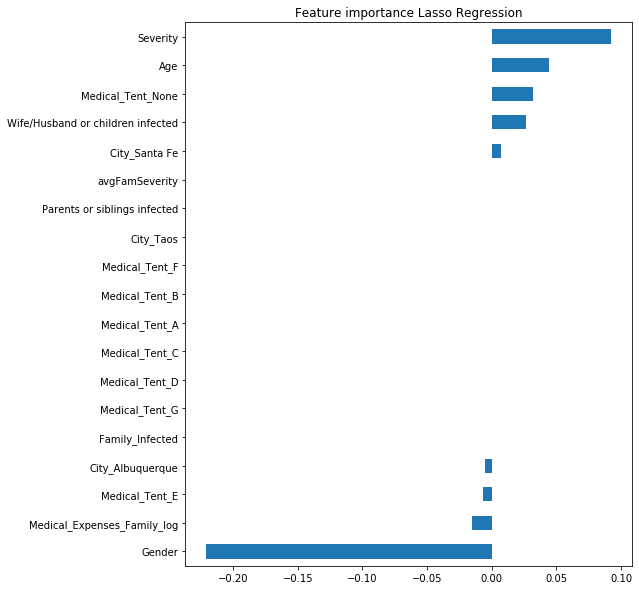

In [92]:
coef=coef.sort_values()
plt.figure(figsize=(8,10))
coef.plot(kind = "barh")
plt.title("Feature importance Lasso Regression")
plt.show()

Using the Lasso Regression feature selection method we could see the variables that we should use in the model are:
* Severity
* Age
* Medical_Tent_None
* Wife/Husband or children infected
* City_Santa Fe
* City_Albuquerque
* Medical_Tent_E 
* Medical_Expenses_Family_log
* Gender

## Ridge Regression

In [93]:
ridge = RidgeCV()
ridge.fit(X=X_temp, y=y)
coef_ridge = pd.Series(ridge.coef_,index=X_temp.columns)
coef_ridge

Severity                             0.105396
Parents or siblings infected         0.016185
Wife/Husband or children infected    0.049359
Age                                  0.078557
City_Santa Fe                        0.012485
City_Albuquerque                    -0.011162
City_Taos                           -0.004304
Medical_Tent_None                   -0.007236
Medical_Tent_F                      -0.026788
Medical_Tent_B                      -0.021865
Medical_Tent_A                      -0.016167
Medical_Tent_E                      -0.041714
Medical_Tent_C                      -0.009900
Medical_Tent_D                      -0.031331
Medical_Tent_G                       0.008634
Medical_Expenses_Family_log         -0.040973
Family_Infected                      0.004822
avgFamSeverity                      -0.005607
Gender                              -0.234331
dtype: float64

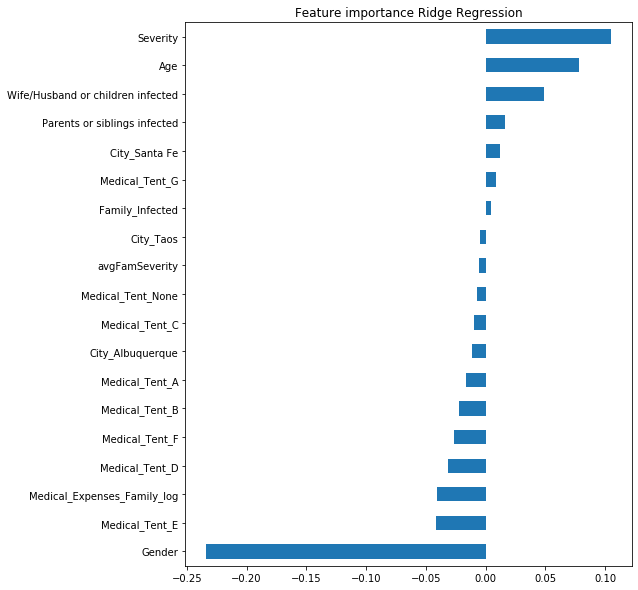

In [94]:
coef=coef_ridge.sort_values()
plt.figure(figsize=(8,10))
coef.plot(kind = "barh")
plt.title("Feature importance Ridge Regression")
plt.show()

Using the Ridge Regression feature selection method we could see (excluding the threshold -0.04 > x < 0.07) the variables that we should use in the model are:
* Severity
* Parents or siblings infected 
* Wife/Husband or children infected
* Age
* Medical_Expenses_Family_log
* Medical_Tent_E
* Gender

## Feature Importance Random Forest 

In [95]:
clf=RandomForestClassifier()
clf.fit(X_temp,y)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

<Figure size 576x720 with 0 Axes>

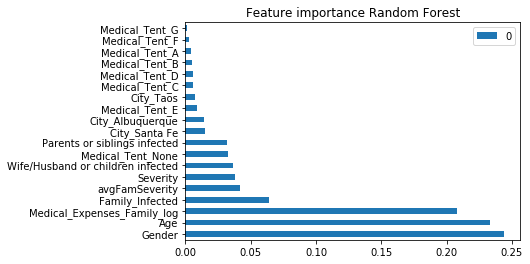

In [96]:
fi=pd.DataFrame(clf.feature_importances_, index=X_temp.columns).sort_values(by=0, ascending = False)
plt.figure(figsize=(8,10))
fi.plot(kind = "barh")
plt.title("Feature importance Random Forest")
plt.show()

In [100]:
coef_clf = pd.Series(clf.feature_importances_,index=X_temp.columns)
coef_clf

Severity                             0.037859
Parents or siblings infected         0.031599
Wife/Husband or children infected    0.036439
Age                                  0.233528
City_Santa Fe                        0.014958
City_Albuquerque                     0.014171
City_Taos                            0.007091
Medical_Tent_None                    0.032717
Medical_Tent_F                       0.002589
Medical_Tent_B                       0.005461
Medical_Tent_A                       0.004114
Medical_Tent_E                       0.008801
Medical_Tent_C                       0.006030
Medical_Tent_D                       0.005827
Medical_Tent_G                       0.001352
Medical_Expenses_Family_log          0.207616
Family_Infected                      0.063857
avgFamSeverity                       0.041870
Gender                               0.244120
dtype: float64

Using the Random Forest feature selection method we could see (excluding the threshold x <0.03) the variables that we should use in the model are:
* Severity
* Parents or siblings infected 
* Wife/Husband or children infected
* Age
* Medical_Tent_None
* Medical_Expenses_Family_log
* Family_Infected
* avgFamSeverity
* Gender

### Drop features

In [130]:
X = X[lasso_features]

In [131]:
X.columns

Index(['Severity', 'Wife/Husband or children infected', 'Age', 'City_Santa Fe',
       'City_Albuquerque', 'Medical_Tent_None', 'Medical_Tent_E',
       'Medical_Expenses_Family_log', 'Gender'],
      dtype='object')

**Some conclusions related to feature selection**

After trying several methods for feature selection such as: RFE; Lasso Regression; Ridge Regression and Feature Importance Random Forest we feed the different variables in to model using an iterative process again and reach the conclusion that the best feature selection method is Lasso Regression so we end up using the feature below:
* Severity
* Age
* Medical_Tent_None
* Wife/Husband or children infected
* City_Santa Fe
* City_Albuquerque
* Medical_Tent_E 
* Medical_Expenses_Family_log
* Gender

<hr>
<a class="anchor" id="model">

### 7. Modelling
    
</a>

## Train and Validation Normalized

In [132]:
X_train, X_val,y_train,y_val = split_scale(X,y,"StandardScaler",0.3)
X_train = pd.DataFrame(X_train, columns=X.columns)
X_val = pd.DataFrame(X_val, columns=X.columns)

## Classifier

In [133]:
model_list = [MLPClassifier(),LogisticRegression(),RandomForestClassifier(),
              KNeighborsClassifier(), GradientBoostingClassifier(),GaussianNB(),
              LogisticRegressionCV(),RidgeClassifier(),SVC(), LinearSVC(), XGBClassifier(), AdaBoostClassifier()]

model_compare(model_list)

,model,train_score,val_score
0,"MLPClassifier(activation='relu', alpha=0.0001,...",0.851911,0.825926
2,"RandomForestClassifier(bootstrap=True, ccp_alp...",0.980892,0.825926
4,"GradientBoostingClassifier(ccp_alpha=0.0, crit...",0.894904,0.825926
8,"SVC(C=1.0, break_ties=False, cache_size=200, c...",0.842357,0.825926
7,"RidgeClassifier(alpha=1.0, class_weight=None, ...",0.797771,0.814815
9,"LinearSVC(C=1.0, class_weight=None, dual=True,...",0.802548,0.811111
10,"XGBClassifier(base_score=0.5, booster=None, co...",0.976115,0.811111
1,"LogisticRegression(C=1.0, class_weight=None, d...",0.791401,0.8
3,"KNeighborsClassifier(algorithm='auto', leaf_si...",0.855096,0.8
6,"LogisticRegressionCV(Cs=10, class_weight=None,...",0.791401,0.8


In [134]:
model_compare_kf(model_list)

,model,train_score,train_std,val_score,val_std
0,"MLPClassifier(activation='relu', alpha=0.0001,...",0.849,0.01,0.83,0.02
2,"RandomForestClassifier(bootstrap=True, ccp_alp...",0.981,0,0.81,0.02
8,"SVC(C=1.0, break_ties=False, cache_size=200, c...",0.837,0.01,0.81,0.03
4,"GradientBoostingClassifier(ccp_alpha=0.0, crit...",0.899,0.01,0.798,0.04
3,"KNeighborsClassifier(algorithm='auto', leaf_si...",0.858,0,0.791,0.02
6,"LogisticRegressionCV(Cs=10, class_weight=None,...",0.802,0.01,0.791,0.02
7,"RidgeClassifier(alpha=1.0, class_weight=None, ...",0.803,0.01,0.791,0.02
11,"AdaBoostClassifier(algorithm='SAMME.R', base_e...",0.841,0.01,0.791,0.04
1,"LogisticRegression(C=1.0, class_weight=None, d...",0.8,0.01,0.79,0.02
10,"XGBClassifier(base_score=0.5, booster=None, co...",0.969,0,0.789,0.04


In [135]:
#creating instance of XGB Classifier to finetune
model = GradientBoostingClassifier()
model.fit(X_train,y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [136]:
print(classification_report(y_val, model.predict(X_val)))
print(confusion_matrix(y_val, model.predict(X_val)))

              precision    recall  f1-score   support

           0       0.79      0.75      0.77       104
           1       0.85      0.87      0.86       166

    accuracy                           0.83       270
   macro avg       0.82      0.81      0.81       270
weighted avg       0.82      0.83      0.83       270

[[ 78  26]
 [ 21 145]]


<hr>
<a class="anchor" id="finetune">

### 8. Finetuning
    
</a>

In [144]:
#### KEEEP UNTIL LAST VERSION THEN DELETE

def optxgb(X_train, y_train, X_test, y_test, trial):
    #param_list
    n_estimators = trial.suggest_int('n_estimators', 0, 1000)
    max_depth = trial.suggest_int('max_depth', 1, 40)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 20)
    learning_rate = trial.suggest_discrete_uniform('learning_rate', 0.001, 0.2, 0.001)
    subsample = trial.suggest_discrete_uniform('subsample', 0.5, 0.9, 0.1)
    reg_lambda = trial.suggest_discrete_uniform('reg_lambda', 0, 1, 0.001)
    reg_alpha = trial.suggest_discrete_uniform('reg_alpha', 0, 1, 0.001)
    colsample_bytree = trial.suggest_discrete_uniform('colsample_bytree', 0.5, 0.9, 0.1)

    xgboost_tuna = XGBClassifier(
        random_state=1, 
        n_estimators = n_estimators,
        max_depth = max_depth,
        min_child_weight = min_child_weight,
        learning_rate = learning_rate,
        subsample = subsample,
        reg_lambda = reg_lambda,
        reg_alpha = reg_alpha,
        colsample_bytree = colsample_bytree,
    )
    xgboost_tuna.fit(X_train, y_train)
    tuna_pred_test = xgboost_tuna.predict(X_val)
    
    return (metrics.accuracy_score(y_test, tuna_pred_test))

def opt_mlp(X_train, y_train, X_test, y_test, trial):
    #param_list
    activation = trial.suggest_categorical('activation', ['relu', 'logistic', 'tanh'])
    solver = trial.suggest_categorical('solver', ['adam', 'sgd','lbfgs'])
    batch_size = trial.suggest_int('batch_size', 100, 600, 100)
    max_iter = trial.suggest_int('max_iter', 100, 1000, 100)
    learning_rate = trial.suggest_categorical('learning_rate', ['constant','adaptive'])
    learning_rate_init = trial.suggest_discrete_uniform('learning_rate_init', 0.001, 0.1, 0.001)
    alpha = trial.suggest_discrete_uniform('alpha', 0.0001, 0.3, 0.0001)
    
    n_layers = trial.suggest_int('n_layers', 1, 5)
    layers = []
    for i in range(n_layers):
        layers.append(trial.suggest_int(f'n_units_{i}', 1, 128))
    
    MLP_model = MLPClassifier(
        random_state=1, 
        alpha = alpha,
        activation = activation,
        solver=solver,
        batch_size = batch_size,
        max_iter= max_iter,
        learning_rate = learning_rate,
        learning_rate_init = learning_rate_init,
        hidden_layer_sizes=tuple(layers)
    )
    MLP_model.fit(X_train, y_train)
    tuna_pred_test = MLP_model.predict(X_test)
    
    return (metrics.accuracy_score(y_test, tuna_pred_test))



In [139]:
opt = opt_gdb
study = optuna.create_study(direction = 'maximize')
study.optimize(functools.partial(opt, X_train, y_train, X_val, y_val), n_trials=100)

[I 2020-05-29 19:09:34,631] Finished trial#0 with value: 0.8726114649681529 with parameters: {'n_estimators': 526, 'max_depth': 39, 'criterion': 'friedman_mse', 'learning_rate': 0.2, 'subsample': 0.8, 'loss': 'deviance', 'min_samples_split': 11, 'min_samples_leaf': 3, 'min_weight_fraction_leaf': 0.201, 'max_features': 8}. Best is trial#0 with value: 0.8726114649681529.
[I 2020-05-29 19:09:35,684] Finished trial#1 with value: 0.7070063694267515 with parameters: {'n_estimators': 557, 'max_depth': 12, 'criterion': 'mae', 'learning_rate': 0.14100000000000001, 'subsample': 0.9, 'loss': 'deviance', 'min_samples_split': 16, 'min_samples_leaf': 6, 'min_weight_fraction_leaf': 0.40800000000000003, 'max_features': 5}. Best is trial#0 with value: 0.8726114649681529.
[I 2020-05-29 19:09:35,833] Finished trial#2 with value: 0.7834394904458599 with parameters: {'n_estimators': 144, 'max_depth': 33, 'criterion': 'friedman_mse', 'learning_rate': 0.082, 'subsample': 0.6, 'loss': 'deviance', 'min_samples

[I 2020-05-29 19:10:03,616] Finished trial#42 with value: 0.9681528662420382 with parameters: {'n_estimators': 588, 'max_depth': 27, 'criterion': 'friedman_mse', 'learning_rate': 0.085, 'subsample': 0.8, 'loss': 'exponential', 'min_samples_split': 5, 'min_samples_leaf': 17, 'min_weight_fraction_leaf': 0.059000000000000004, 'max_features': 7}. Best is trial#28 with value: 0.9792993630573248.
[I 2020-05-29 19:10:04,795] Finished trial#43 with value: 0.9792993630573248 with parameters: {'n_estimators': 705, 'max_depth': 30, 'criterion': 'friedman_mse', 'learning_rate': 0.128, 'subsample': 0.8, 'loss': 'exponential', 'min_samples_split': 19, 'min_samples_leaf': 15, 'min_weight_fraction_leaf': 0.024, 'max_features': 6}. Best is trial#28 with value: 0.9792993630573248.
[I 2020-05-29 19:10:05,267] Finished trial#44 with value: 0.7229299363057324 with parameters: {'n_estimators': 738, 'max_depth': 30, 'criterion': 'friedman_mse', 'learning_rate': 0.127, 'subsample': 0.9, 'loss': 'exponential',

[I 2020-05-29 19:12:54,377] Finished trial#84 with value: 0.9792993630573248 with parameters: {'n_estimators': 853, 'max_depth': 39, 'criterion': 'friedman_mse', 'learning_rate': 0.151, 'subsample': 0.9, 'loss': 'exponential', 'min_samples_split': 20, 'min_samples_leaf': 4, 'min_weight_fraction_leaf': 0.032, 'max_features': 5}. Best is trial#48 with value: 0.9808917197452229.
[I 2020-05-29 19:12:58,090] Finished trial#85 with value: 0.9124203821656051 with parameters: {'n_estimators': 967, 'max_depth': 40, 'criterion': 'mae', 'learning_rate': 0.166, 'subsample': 0.9, 'loss': 'deviance', 'min_samples_split': 18, 'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.062, 'max_features': 4}. Best is trial#48 with value: 0.9808917197452229.
[I 2020-05-29 19:12:59,711] Finished trial#86 with value: 0.9808917197452229 with parameters: {'n_estimators': 804, 'max_depth': 34, 'criterion': 'friedman_mse', 'learning_rate': 0.135, 'subsample': 0.9, 'loss': 'deviance', 'min_samples_split': 16, 'min_

In [140]:
study.best_params

{'n_estimators': 895,
 'max_depth': 28,
 'criterion': 'friedman_mse',
 'learning_rate': 0.17300000000000001,
 'subsample': 0.8,
 'loss': 'exponential',
 'min_samples_split': 20,
 'min_samples_leaf': 4,
 'min_weight_fraction_leaf': 0.0,
 'max_features': 5}

In [66]:
GBCmodel = GradientBoostingClassifier(**{'n_estimators': 186,
 'max_depth': 5,
 'criterion': 'mse',
 'learning_rate': 0.076,
 'subsample': 0.5,
 'loss': 'deviance',
 'min_samples_split': 18,
 'min_samples_leaf': 12,
 'min_weight_fraction_leaf': 0.09,
 'max_features': 7},random_state=150) 
GBCmodel.fit(X_train,y_train)
GBCmodel.score(X_val,y_val)

0.8666666666666667

### Final classifier

In [67]:
#fitting scale on full X dataframe
scaler_final = StandardScaler().fit(X)
X_train = pd.DataFrame(scaler_final.transform(X),columns=X.columns)


In [68]:
#fitting best performing model on full X dataframe
GBCmodel = GradientBoostingClassifier(**{'n_estimators': 186,
 'max_depth': 5,
 'criterion': 'mse',
 'learning_rate': 0.076,
 'subsample': 0.5,
 'loss': 'deviance',
 'min_samples_split': 18,
 'min_samples_leaf': 12,
 'min_weight_fraction_leaf': 0.09,
 'max_features': 7},random_state=150) 
GBCmodel.fit(X_train,y)
GBCmodel.score(X_train,y)

0.8685968819599109

In [69]:
#features used
X.columns

Index(['Severity', 'Wife/Husband or children infected', 'Age', 'City_Santa Fe',
       'City_Albuquerque', 'Medical_Tent_None', 'Medical_Tent_E',
       'Medical_Expenses_Family_log', 'Gender'],
      dtype='object')

<hr>
<a class="anchor" id="test">

# 9. Test Submission
    
</a>

### Same pre-processing as Train

In [70]:
Pandemic_test = pd.read_csv("test.csv")

Pandemic_test

,Patient_ID,Family_Case_ID,Severity,Name,Birthday_year,Parents or siblings infected,Wife/Husband or children infected,Medical_Expenses_Family,Medical_Tent,City
0,901,49242,3,Mr. Jody Pedro,NaN,0,0,203,NaN,Santa Fe
1,902,10400,3,Mr. Kevin Brent,1988.0,0,0,631,NaN,Santa Fe
2,903,10795,3,Mr. Frankie Cary,1981.0,1,0,376,NaN,Albuquerque
3,904,62440,3,Mr. Rick Pete,NaN,0,1,405,NaN,Albuquerque
4,905,81311,2,Mr. Matthew Erick,1996.0,0,0,378,NaN,Santa Fe
5,906,128471,2,Mr. Bryan Santiago,1994.0,0,0,364,NaN,Santa Fe
6,907,24058,3,Mr. Tom Miguel,2002.0,0,1,405,NaN,Albuquerque
7,908,54346,3,Mrs. Lucia Angelica,1985.0,0,0,217,NaN,Taos
8,909,23128,2,Mr. Allan Vincent,1980.0,0,0,364,NaN,Santa Fe
9,910,71576,3,Mrs. Lela Judy,1982.0,0,0,202,NaN,Albuquerque


In [71]:

#filling Medical tent
Pandemic_test['Medical_Tent'].fillna('None',inplace=True)

#filling in missing birthday year
Birthday_imputed_test =imputer.transform(Pandemic_test[['Birthday_year']])
Birthday_imputed_test = pd.DataFrame(Birthday_imputed_test, columns = Pandemic_test[['Birthday_year']].columns, index = Pandemic_test.index)
Birthday_imputed_test = Birthday_imputed_test.astype(int)
Pandemic_test = Pandemic_test.assign(Birthday_year=Birthday_imputed_test['Birthday_year'])

#replacing year with age feature
Pandemic_test['Age']=2020-Pandemic_test['Birthday_year']
Pandemic_test.drop(['Birthday_year'],axis=1,inplace=True)

#encoding categorical
encode = ['City', 'Medical_Tent']
encoded = ce_one_hot.fit_transform(Pandemic_test[encode])
Pandemic_test = pd.concat([Pandemic_test, encoded], axis=1)
Pandemic_test.drop(encode,axis=1,inplace=True)


#complete_test.drop('City_Albuquerque', axis=1, inplace=True)

#adding features (logging Med expenses, Family infected, fam_dead)
Pandemic_test["Medical_Expenses_Family_log"] = Pandemic_test.Medical_Expenses_Family.apply(lambda x: np.log(x+1))

#"Gender": If the name begins with Mr. or Master it is a male (encoded:0), if not, it is a female (encoded:1)
Pandemic_test["NameSplit"]=Pandemic_test.Name.str.rsplit()
Pandemic_test["Gender"] = Pandemic_test.NameSplit.apply(lambda x: 0 if x[0]=="Mr." or x[0]=="Master" else(1))
Pandemic_test.drop(columns="NameSplit",inplace=True)

#family infected
Pandemic_test = Pandemic_test.merge(fcid, left_on="Family_Case_ID", right_on = fcid.index)
Pandemic_test["Family_Infected"] = Pandemic_test.Family_Case_ID_y - 1 #subtract the person
Pandemic_test = Pandemic_test.merge(grouped_severity, left_on="Family_Case_ID", right_on = grouped_severity.index)



#fam_dead
Pandemic_test = Pandemic_test.merge(deceased_fam, left_on = "Family_Case_ID", right_on = deceased_fam.index)

Pandemic_test["dead_fam"] = Pandemic_test[1].apply(lambda x : 0 if x<=0 else x)

Pandemic_test.rename(columns={"avgFamSeverity_x":"avgFamSeverity"}, inplace=True)

#extracting Patient IDs
Patient_ID=pd.DataFrame(Pandemic_test["Patient_ID"])


In [72]:

#dropping features
Pandemic_test.drop(["Family_Case_ID","Patient_ID","Family_Case_ID_x","Family_Case_ID_y","Name",1], axis=1, inplace=True)
todrop2 = ["Medical_Expenses_Family","dead_fam"]
Pandemic_test.drop(todrop2,axis=1,inplace=True)
X_test = Pandemic_test.copy()

X_test = X_test[lasso_features]

#scaling
X_test = pd.DataFrame(scaler_final.transform(X_test),columns=X_test.columns)

### Prediction

In [73]:
y_pred = pd.DataFrame(GBCmodel.predict(X_test))
y_pred = y_pred.merge(Patient_ID, left_index = True , right_index = True)
y_pred = y_pred[['Patient_ID', 0]].sort_values(by="Patient_ID")
y_pred.rename(columns = {0 : "Deceased"}, inplace = True)
#y_pred.to_csv('sub_lasso_gb2.csv', index = False)

<hr>
<a class="anchor" id="conclusion">

### 10. Conclusion
    
</a>